In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, make_scorer, confusion_matrix,
                             roc_curve, precision_recall_curve, auc)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# === Step 1: Load Data ===
df = pd.read_csv("Final_v3.csv")
test_df = pd.read_csv("Final_test_v3.csv")

In [3]:
# === Step 2: Preprocessing ===
print("Data preprocessing...")
le = LabelEncoder()
df["addr_state"] = le.fit_transform(df["addr_state"])
test_df["addr_state"] = le.transform(test_df["addr_state"])

df["unemployment_rate"] = df["unemployment_rate"].fillna(df["unemployment_rate"].mean())
test_df["unemployment_rate"] = test_df["unemployment_rate"].fillna(df["unemployment_rate"].mean())

Data preprocessing...


In [4]:
# === Step 3: Feature Engineering ===
interaction_pairs = {
    "int_rate_term": ["avg_interest_rate", "term"],
    "poverty_term": ["Poverty Rate", "term"],
    "term_util": ["term", "revol_util"],
    "inq_dti": ["inq_last_6mths", "dti"],
    "unemp_dti": ["unemployment_rate", "dti"],
    "uninsured_dti": ["Percent Uninsured", "dti"],
    "edu_inc": ["Population 25 years and over with Bachelor degree or higher", "annual_inc"],
    "emp_inc": ["emp_length", "annual_inc"],
    "loan_bal": ["loan_amnt", "revol_bal"],
    "install_util": ["installment", "revol_util"],
    "inflation_install": ["implicit_regional_price_deflator", "installment"],
    "price_purpose": ["regional_price_parities_rpps_all_items", "purpose"],
    "income_bal": ["state_real_per_capita_personal_income", "revol_bal"],
    "inq_gdp": ["inq_last_6mths", "state_gdp_growth__summary_"],
    "emp_growth": ["emp_length", "state_total_employment_growth"]
}

for name, (col1, col2) in interaction_pairs.items():
    df[name] = df[col1] * df[col2]
    test_df[name] = test_df[col1] * test_df[col2]

In [5]:
# === Step 4: Define Features ===
target_col = "loan_status"
base_features = [col for col in df.columns if col != target_col]
final_features = list(dict.fromkeys(base_features + list(interaction_pairs.keys())))

X_train = df[final_features]
y_train = df[target_col]
X_test = test_df[final_features]
y_test = test_df[target_col]

In [6]:
# === Step 5: Pipeline + Grid Search with class_weight ===
print("Starting grid search...")
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l1", "l2"],
    "clf__solver": ["liblinear"],
    "clf__class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid, scoring=make_scorer(f1_score), cv=cv, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print("\n✅ Best Parameters:", grid.best_params_)
print("✅ Best CV F1 Score:", grid.best_score_)

Starting grid search...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__penalty': ['l1', 'l2'],
                         'clf__solver': ['liblinear']},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=1)


✅ Best Parameters: {'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
✅ Best CV F1 Score: 0.3703745924986029


In [7]:
# === Step 6: Predict Probabilities ===
best_model = grid.best_estimator_
y_train_prob = best_model.predict_proba(X_train)[:, 1]
y_test_prob = best_model.predict_proba(X_test)[:, 1]


In [8]:
# === Step 7: Auto Threshold (maximize F1 or G-mean) ===
def find_best_threshold(y_true, y_prob, metric='f1'):
    """
    Find the best threshold based on F1 score or G-mean
    
    Args:
        y_true: True labels
        y_prob: Predicted probabilities
        metric: 'f1' or 'gmean' - which metric to optimize
    """
    thresholds = np.linspace(0.05, 0.95, 100)
    scores = []
    
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        
        if metric == 'f1':
            score = f1_score(y_true, y_pred)
        elif metric == 'gmean':
            # Calculate G-mean
            conf_matrix = confusion_matrix(y_true, y_pred)
            tn, fp, fn, tp = conf_matrix.ravel()
            tpr = tp / (tp + fn + 1e-6)  # Sensitivity/Recall
            tnr = tn / (tn + fp + 1e-6)  # Specificity
            score = np.sqrt(tpr * tnr)
        
        scores.append(score)
    
    best_idx = np.argmax(scores)
    return thresholds[best_idx], scores[best_idx]

# Find best threshold based on F1-score
best_thresh_f1, best_f1 = find_best_threshold(y_train, y_train_prob, 'f1')
print(f"\n📌 Best Threshold (F1) = {best_thresh_f1:.2f}, Train F1 = {best_f1:.4f}")

# Find best threshold based on G-mean
best_thresh_gmean, best_gmean = find_best_threshold(y_train, y_train_prob, 'gmean')
print(f"📌 Best Threshold (G-mean) = {best_thresh_gmean:.2f}, Train G-mean = {best_gmean:.4f}")

# We'll use the F1 threshold as primary but report both metrics
best_thresh = best_thresh_f1



📌 Best Threshold (F1) = 0.54, Train F1 = 0.3731
📌 Best Threshold (G-mean) = 0.49, Train G-mean = 0.6398


In [9]:
# === Step 8: Enhanced Evaluation ===
def evaluate_model(y_true, y_pred, y_prob, dataset_name):
    """Enhanced evaluation function that includes accuracy, precision, recall, F1, AUC, specificity and G-mean"""
    # Calculate confusion matrix and metrics
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    # Standard metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)  # Same as sensitivity/TPR
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    
    # Additional metrics
    specificity = tn / (tn + fp)  # TNR
    gmean = np.sqrt(recall * specificity)  # G-mean is sqrt(sensitivity * specificity)
    
    print(f"\n📊 {dataset_name} Evaluation")
    print("Confusion Matrix:")
    print(f"TN: {tn}, FP: {fp}")
    print(f"FN: {fn}, TP: {tp}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall/Sensitivity: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score (weighted avg): {f1:.4f}")
    print(f"G-mean: {gmean:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "f1": f1,
        "gmean": gmean,
        "auc": auc,
        "confusion_matrix": conf_matrix
    }

# Generate predictions using the best threshold
y_train_pred = (y_train_prob >= best_thresh).astype(int)
y_test_pred = (y_test_prob >= best_thresh).astype(int)

# Evaluate the model
train_metrics = evaluate_model(y_train, y_train_pred, y_train_prob, "Train Set")
test_metrics = evaluate_model(y_test, y_test_pred, y_test_prob, "Test Set")

# Print clarification about G-mean and F1-score usage
print("\nNote: G-mean is mainly used for threshold selection in imbalanced datasets,")
print("while F1-score serves both for threshold selection and for evaluating overall model performance.")


📊 Train Set Evaluation
Confusion Matrix:
TN: 107177, FP: 38195
FN: 13520, TP: 15387
Accuracy: 0.7033
Precision: 0.2872
Recall/Sensitivity: 0.5323
Specificity: 0.7373
F1 Score (weighted avg): 0.3731
G-mean: 0.6264
AUC-ROC: 0.6938

📊 Test Set Evaluation
Confusion Matrix:
TN: 49691, FP: 67570
FN: 5259, TP: 6918
Accuracy: 0.4373
Precision: 0.0929
Recall/Sensitivity: 0.5681
Specificity: 0.4238
F1 Score (weighted avg): 0.1596
G-mean: 0.4907
AUC-ROC: 0.4664

Note: G-mean is mainly used for threshold selection in imbalanced datasets,
while F1-score serves both for threshold selection and for evaluating overall model performance.


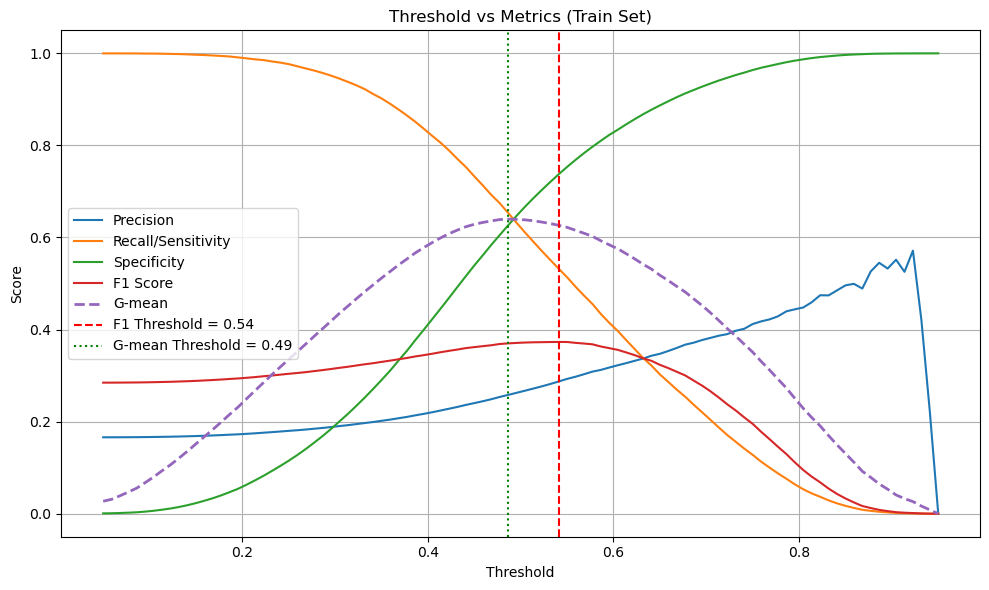

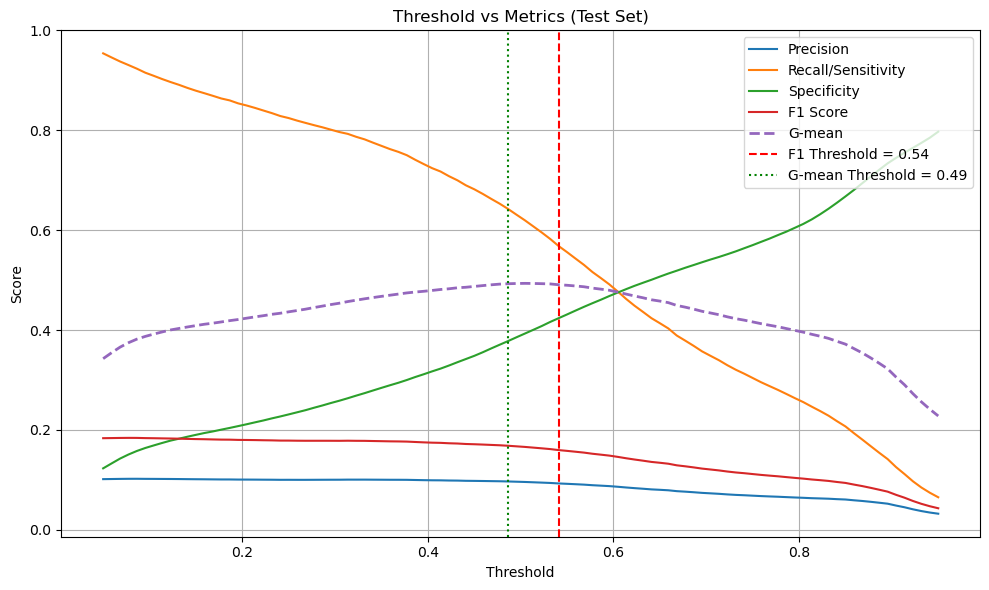

In [10]:
# === Step 9: Threshold Curve Visualization ===
def plot_threshold_metrics(y_true, y_prob, title):
    thresholds = np.linspace(0.05, 0.95, 100)
    precisions, recalls, f1s, gmeans, specificities = [], [], [], [], []

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        
        # Calculate metrics
        conf_matrix = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = conf_matrix.ravel()
        
        # Handle division by zero
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        # Calculate specificity and G-mean
        specificity = tn / (tn + fp + 1e-6)
        gmean = np.sqrt(recall * specificity)
        
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        gmeans.append(gmean)
        specificities.append(specificity)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label="Precision")
    plt.plot(thresholds, recalls, label="Recall/Sensitivity")
    plt.plot(thresholds, specificities, label="Specificity")
    plt.plot(thresholds, f1s, label="F1 Score")
    plt.plot(thresholds, gmeans, label="G-mean", linestyle="--", linewidth=2)
    
    # Mark both thresholds
    plt.axvline(best_thresh_f1, color='red', linestyle='--', 
                label=f'F1 Threshold = {best_thresh_f1:.2f}')
    plt.axvline(best_thresh_gmean, color='green', linestyle=':', 
                label=f'G-mean Threshold = {best_thresh_gmean:.2f}')
    
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Threshold vs Metrics ({title})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Plot threshold metrics for train and test sets
plot_threshold_metrics(y_train, y_train_prob, "Train Set")
plot_threshold_metrics(y_test, y_test_prob, "Test Set")

In [11]:
# === Step 10: Compare F1 vs G-mean thresholds ===
# Evaluate using G-mean threshold
y_train_pred_gmean = (y_train_prob >= best_thresh_gmean).astype(int)
y_test_pred_gmean = (y_test_prob >= best_thresh_gmean).astype(int)

print("\n=== Comparison of F1 vs G-mean threshold ===")
# Evaluate with F1 threshold
print("\nResults with F1 threshold:")
train_metrics_f1 = evaluate_model(y_train, y_train_pred, y_train_prob, "Train Set (F1 threshold)")
test_metrics_f1 = evaluate_model(y_test, y_test_pred, y_test_prob, "Test Set (F1 threshold)")

# Evaluate with G-mean threshold
print("\nResults with G-mean threshold:")
train_metrics_gmean = evaluate_model(y_train, y_train_pred_gmean, y_train_prob, "Train Set (G-mean threshold)")
test_metrics_gmean = evaluate_model(y_test, y_test_pred_gmean, y_test_prob, "Test Set (G-mean threshold)")


=== Comparison of F1 vs G-mean threshold ===

Results with F1 threshold:

📊 Train Set (F1 threshold) Evaluation
Confusion Matrix:
TN: 107177, FP: 38195
FN: 13520, TP: 15387
Accuracy: 0.7033
Precision: 0.2872
Recall/Sensitivity: 0.5323
Specificity: 0.7373
F1 Score (weighted avg): 0.3731
G-mean: 0.6264
AUC-ROC: 0.6938

📊 Test Set (F1 threshold) Evaluation
Confusion Matrix:
TN: 49691, FP: 67570
FN: 5259, TP: 6918
Accuracy: 0.4373
Precision: 0.0929
Recall/Sensitivity: 0.5681
Specificity: 0.4238
F1 Score (weighted avg): 0.1596
G-mean: 0.4907
AUC-ROC: 0.4664

Results with G-mean threshold:

📊 Train Set (G-mean threshold) Evaluation
Confusion Matrix:
TN: 91028, FP: 54344
FN: 10012, TP: 18895
Accuracy: 0.6307
Precision: 0.2580
Recall/Sensitivity: 0.6536
Specificity: 0.6262
F1 Score (weighted avg): 0.3700
G-mean: 0.6398
AUC-ROC: 0.6938

📊 Test Set (G-mean threshold) Evaluation
Confusion Matrix:
TN: 44311, FP: 72950
FN: 4354, TP: 7823
Accuracy: 0.4028
Precision: 0.0969
Recall/Sensitivity: 0.642

In [12]:
# === Step 11: Optional - Baseline model comparison ===
print("\n=== Comparing with baseline model (without threshold optimization) ===")
# Create a baseline model with default threshold (0.5)
baseline_train_pred = (y_train_prob >= 0.5).astype(int)
baseline_test_pred = (y_test_prob >= 0.5).astype(int)

# Evaluate baseline model
baseline_train_metrics = evaluate_model(y_train, baseline_train_pred, y_train_prob, "Train Set (Baseline)")
baseline_test_metrics = evaluate_model(y_test, baseline_test_pred, y_test_prob, "Test Set (Baseline)")

# Print summary
print("\n=== Summary ===")
print(f"Optimized F1 threshold: {best_thresh_f1:.4f}, Test F1: {test_metrics_f1['f1']:.4f}, Test G-mean: {test_metrics_f1['gmean']:.4f}")
print(f"Optimized G-mean threshold: {best_thresh_gmean:.4f}, Test F1: {test_metrics_gmean['f1']:.4f}, Test G-mean: {test_metrics_gmean['gmean']:.4f}")
print(f"Default threshold (0.5): Test F1: {baseline_test_metrics['f1']:.4f}, Test G-mean: {baseline_test_metrics['gmean']:.4f}")


=== Comparing with baseline model (without threshold optimization) ===

📊 Train Set (Baseline) Evaluation
Confusion Matrix:
TN: 95455, FP: 49917
FN: 10920, TP: 17987
Accuracy: 0.6509
Precision: 0.2649
Recall/Sensitivity: 0.6222
Specificity: 0.6566
F1 Score (weighted avg): 0.3716
G-mean: 0.6392
AUC-ROC: 0.6938

📊 Test Set (Baseline) Evaluation
Confusion Matrix:
TN: 45653, FP: 71608
FN: 4563, TP: 7614
Accuracy: 0.4115
Precision: 0.0961
Recall/Sensitivity: 0.6253
Specificity: 0.3893
F1 Score (weighted avg): 0.1666
G-mean: 0.4934
AUC-ROC: 0.4664

=== Summary ===
Optimized F1 threshold: 0.5409, Test F1: 0.1596, Test G-mean: 0.4907
Optimized G-mean threshold: 0.4864, Test F1: 0.1683, Test G-mean: 0.4927
Default threshold (0.5): Test F1: 0.1666, Test G-mean: 0.4934


In [13]:
# === Step 12: Feature Importance Analysis ===
def analyze_feature_importance(model, feature_names):
    """Analyze feature importance from the logistic regression model"""
    # Extract the logistic regression model from the pipeline
    if hasattr(model, 'named_steps') and 'clf' in model.named_steps:
        logistic_model = model.named_steps['clf']
        
        # Get feature coefficients
        if hasattr(logistic_model, 'coef_'):
            # For binary classification, there's only one set of coefficients
            coeffs = logistic_model.coef_[0]
            
            # Combine feature names with their coefficients
            importance = pd.DataFrame({
                'Feature': feature_names,
                'Coefficient': coeffs,
                'Absolute_Coefficient': np.abs(coeffs)
            })
            
            # Sort by absolute coefficient value (importance)
            importance = importance.sort_values('Absolute_Coefficient', ascending=False)
            
            return importance
    
    return None


In [14]:
# === Step 13: Feature Importance Visualization ===
def plot_feature_importance(importance_df, title="Feature Importance", top_n=20):
    """Plot feature importance as a horizontal bar chart"""
    if importance_df is None or len(importance_df) == 0:
        print("No feature importance data to plot.")
        return
    
    # Get top N features
    if len(importance_df) > top_n:
        plot_data = importance_df.head(top_n).copy()
    else:
        plot_data = importance_df.copy()
    
    # Sort for plotting (ascending for horizontal bar chart)
    plot_data = plot_data.sort_values('Absolute_Coefficient')
    
    # Create a colormap based on coefficient signs
    colors = ['red' if c < 0 else 'green' for c in plot_data['Coefficient']]
    
    # Plot
    plt.figure(figsize=(10, max(6, len(plot_data) * 0.3)))
    plt.barh(plot_data['Feature'], plot_data['Absolute_Coefficient'], color=colors)
    plt.xlabel('Absolute Coefficient Value')
    plt.title(f'Top {len(plot_data)} Most Important Features')
    
    # Add a legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', label='Positive Effect (Higher odds of default)'),
        Patch(facecolor='red', label='Negative Effect (Lower odds of default)')
    ]
    plt.legend(handles=legend_elements)
    
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [15]:
# === Step 14: Interaction Terms Analysis ===
def analyze_interaction_terms(model, X, y, interaction_pairs):
    """Analyze the importance of interaction terms"""
    # Create a dataframe to store results
    results = []
    
    # Loop through each interaction term
    for idx, (name, (col1, col2)) in enumerate(interaction_pairs.items()):
        # Create a feature set with this interaction term removed
        X_without = X.drop(columns=[name])
        
        # Train a new pipeline with the same parameters
        pipeline_without = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                C=model.named_steps['clf'].C,
                penalty=model.named_steps['clf'].penalty,
                solver=model.named_steps['clf'].solver,
                class_weight=model.named_steps['clf'].class_weight,
                max_iter=1000
            ))
        ])
        
        # Fit the model
        pipeline_without.fit(X_without, y)
        
        # Get predictions
        y_prob = pipeline_without.predict_proba(X_without)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)
        
        # Calculate metrics
        auc_value = roc_auc_score(y, y_prob)
        f1_value = f1_score(y, y_pred)
        recall_value = recall_score(y, y_pred)
        precision_value = precision_score(y, y_pred)
        
        # Calculate coefficient in the original model
        feature_idx = list(X.columns).index(name)
        coefficient = model.named_steps['clf'].coef_[0][feature_idx]
        
        # Store results
        results.append({
            'Interaction Term': name,
            'Variable 1': col1,
            'Variable 2': col2,
            'P-Value_Interaction': "",  # Would need statistical test
            'Coefficient_Interaction': coefficient,
            'AUC': auc_value,
            'F1': f1_value,
            'Recall': recall_value,
            'Precision': precision_value,
            'Best_Threshold': best_thresh_f1
        })
    
    # Convert to DataFrame and sort by AUC
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('AUC', ascending=False)
    
    return results_df



=== Analyzing feature importance ===

Top 20 Most Important Features:
                                              Feature  Coefficient  \
20                                        installment     0.652076   
0                                           loan_amnt    -0.555226   
1                                                term     0.500022   
12                               acc_open_past_24mths     0.227125   
15                                         annual_inc    -0.176226   
2                                               grade     0.154350   
16                                                dti     0.140049   
9                                           total_acc    -0.132292   
18                                    fico_range_high    -0.126289   
3                                      home_ownership     0.125692   
17                                     fico_range_low    -0.123678   
30             regional_price_parities_rpps_all_items     0.103826   
6                  

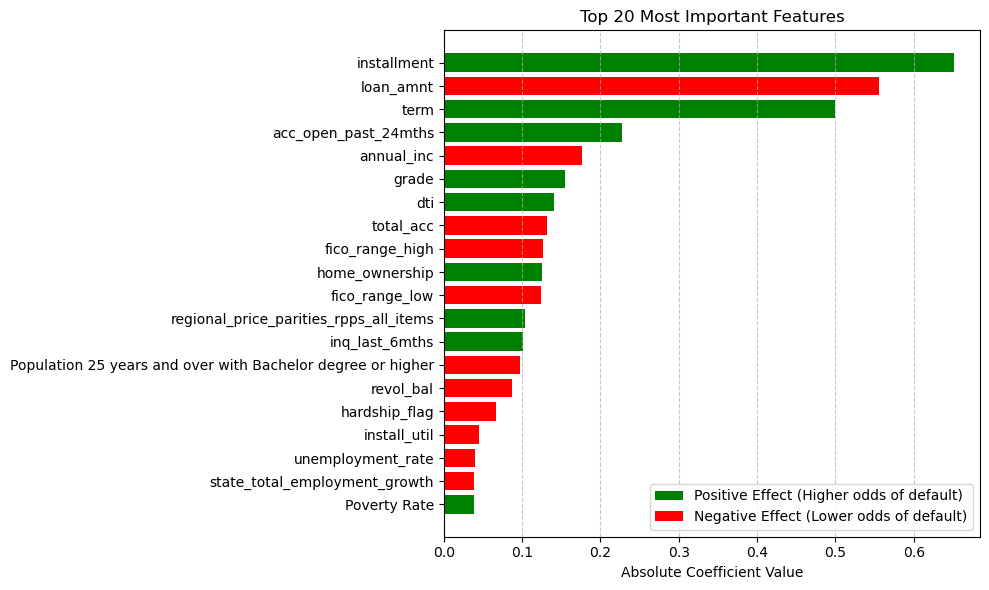


=== Analyzing interaction terms ===

Interaction Terms Analysis:
     Interaction Term                                         Variable 1  \
7             emp_inc                                         emp_length   
6             edu_inc  Population 25 years and over with Bachelor deg...   
12         income_bal              state_real_per_capita_personal_income   
13            inq_gdp                                     inq_last_6mths   
11      price_purpose             regional_price_parities_rpps_all_items   
8            loan_bal                                          loan_amnt   
14         emp_growth                                         emp_length   
1        poverty_term                                       Poverty Rate   
5       uninsured_dti                                  Percent Uninsured   
4           unemp_dti                                  unemployment_rate   
10  inflation_install                   implicit_regional_price_deflator   
2           term_util 

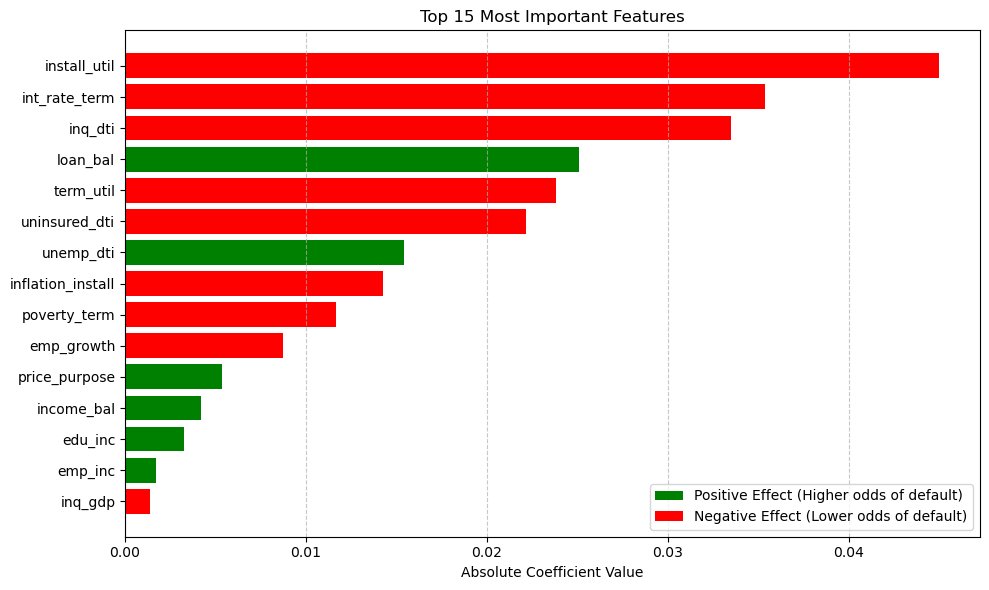

In [16]:
# Run Step 12 - 14
if hasattr(best_model['clf'], 'coef_'):
    print("\n=== Analyzing feature importance ===")
    feature_importance = analyze_feature_importance(best_model, X_train.columns)
    
    # Print top 20 features
    print("\nTop 20 Most Important Features:")
    print(feature_importance.head(20))
    
    # Feature importance visualization
    plot_feature_importance(feature_importance)
    
    # Also analyze interaction terms specifically
    print("\n=== Analyzing interaction terms ===")
    interaction_analysis = analyze_interaction_terms(best_model, X_train, y_train, interaction_pairs)
    print("\nInteraction Terms Analysis:")
    pd.set_option('display.max_columns', None)
    print(interaction_analysis)
    
    # Plot interaction importance
    interaction_importance = feature_importance[feature_importance['Feature'].isin(interaction_pairs.keys())]
    if len(interaction_importance) > 0:
        print("\nInteraction Terms Importance:")
        plot_feature_importance(interaction_importance, "Interaction Terms Importance")

In [17]:
# === VISUALIZATION FUNCTIONS ===

# 1. Confusion Matrix Visualization
def plot_confusion_matrix(cm, title, normalize=False):
    """
    Plot confusion matrix with percentages
    """
    plt.figure(figsize=(8, 6))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2%'
    else:
        fmt = 'd'
    
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', 
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.tight_layout()
    plt.show()
    
    # Also plot the normalized version if not already normalized
    if not normalize:
        plot_confusion_matrix(cm, f"{title} (Normalized)", normalize=True)

# 2. ROC Curve Visualization
def plot_roc_curve(y_true, y_prob, title):
    """
    Plot ROC curve with AUC
    """
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 3. Precision-Recall Curve Visualization
def plot_precision_recall_curve(y_true, y_prob, title):
    """
    Plot Precision-Recall curve
    """
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2, 
             label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.axhline(y=sum(y_true)/len(y_true), color='navy', linestyle='--', 
                label=f'Baseline (Prevalence = {sum(y_true)/len(y_true):.3f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {title}')
    plt.legend(loc="lower left")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 4. Metrics Comparison Visualization
def plot_metrics_comparison(metrics_list, names, title):
    """
    Plot a bar chart comparing metrics across different models/scenarios
    """
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'specificity', 'f1', 'gmean']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(metrics_to_plot))
    width = 0.8 / len(metrics_list)
    
    for i, (metrics, name) in enumerate(zip(metrics_list, names)):
        values = [metrics[m] for m in metrics_to_plot]
        plt.bar(x + i*width - (len(metrics_list)-1)*width/2, values, width, label=name, color=colors[i])
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title(f'Metrics Comparison - {title}')
    plt.xticks(x, metrics_to_plot)
    plt.ylim(0, 1)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(metrics_list))
    plt.grid(True, linestyle='--', alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

# 5. Enhanced Threshold Metrics Visualization
def plot_enhanced_threshold_metrics(y_true, y_prob, title):
    """
    Enhanced threshold metrics visualization with split view
    """
    thresholds = np.linspace(0.05, 0.95, 100)
    precisions, recalls, f1s, gmeans, specificities = [], [], [], [], []

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        
        # Calculate metrics
        conf_matrix = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = conf_matrix.ravel()
        
        # Handle division by zero
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        # Calculate specificity and G-mean
        specificity = tn / (tn + fp + 1e-6)
        gmean = np.sqrt(recall * specificity)
        
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        gmeans.append(gmean)
        specificities.append(specificity)

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: All metrics
    ax1.plot(thresholds, precisions, label="Precision", linestyle='-', linewidth=2)
    ax1.plot(thresholds, recalls, label="Recall/Sensitivity", linestyle='-', linewidth=2)
    ax1.plot(thresholds, specificities, label="Specificity", linestyle='-', linewidth=2)
    ax1.plot(thresholds, f1s, label="F1 Score", linestyle='--', linewidth=2.5)
    ax1.plot(thresholds, gmeans, label="G-mean", linestyle='--', linewidth=2.5)
    
    # Mark both thresholds
    ax1.axvline(best_thresh_f1, color='red', linestyle='--', 
                label=f'F1 Threshold = {best_thresh_f1:.2f}')
    ax1.axvline(best_thresh_gmean, color='green', linestyle=':', 
                label=f'G-mean Threshold = {best_thresh_gmean:.2f}')
    
    ax1.set_xlabel("Threshold")
    ax1.set_ylabel("Score")
    ax1.set_title(f"Threshold vs All Metrics ({title})")
    ax1.legend(loc='best')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Plot 2: Focus on F1 and G-mean
    ax2.plot(thresholds, f1s, label="F1 Score", color='purple', linewidth=3)
    ax2.plot(thresholds, gmeans, label="G-mean", color='teal', linewidth=3)
    
    # Mark both thresholds
    ax2.axvline(best_thresh_f1, color='red', linestyle='--', 
                label=f'F1 Threshold = {best_thresh_f1:.2f}')
    ax2.axvline(best_thresh_gmean, color='green', linestyle=':', 
                label=f'G-mean Threshold = {best_thresh_gmean:.2f}')
    
    # Fill area under the curves
    ax2.fill_between(thresholds, 0, f1s, alpha=0.2, color='purple')
    ax2.fill_between(thresholds, 0, gmeans, alpha=0.2, color='teal')
    
    ax2.set_xlabel("Threshold")
    ax2.set_ylabel("Score")
    ax2.set_title(f"Threshold vs F1 and G-mean ({title})")
    ax2.legend(loc='best')
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# 6. Distribution of Probabilities Visualization
def plot_probability_distribution(y_true, y_prob, title):
    """
    Plot the distribution of predicted probabilities by actual class
    """
    plt.figure(figsize=(10, 6))
    
    # Plot the distribution for each class
    for actual_class in [0, 1]:
        class_mask = (y_true == actual_class)
        class_probs = y_prob[class_mask]
        
        if len(class_probs) > 0:  # Only plot if we have examples
            sns.kdeplot(class_probs, label=f'Actual {actual_class}', 
                       fill=True, common_norm=False)
    
    # Add threshold lines
    plt.axvline(best_thresh_f1, color='red', linestyle='--', 
               label=f'F1 Threshold = {best_thresh_f1:.2f}')
    plt.axvline(best_thresh_gmean, color='green', linestyle=':', 
               label=f'G-mean Threshold = {best_thresh_gmean:.2f}')
    
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title(f'Distribution of Predicted Probabilities - {title}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


=== Running Enhanced Visualizations ===

📊 Train Set (G-mean threshold) Evaluation
Confusion Matrix:
TN: 91028, FP: 54344
FN: 10012, TP: 18895
Accuracy: 0.6307
Precision: 0.2580
Recall/Sensitivity: 0.6536
Specificity: 0.6262
F1 Score (weighted avg): 0.3700
G-mean: 0.6398
AUC-ROC: 0.6938

📊 Test Set (G-mean threshold) Evaluation
Confusion Matrix:
TN: 44311, FP: 72950
FN: 4354, TP: 7823
Accuracy: 0.4028
Precision: 0.0969
Recall/Sensitivity: 0.6424
Specificity: 0.3779
F1 Score (weighted avg): 0.1683
G-mean: 0.4927
AUC-ROC: 0.4664

📊 Train Set (Baseline) Evaluation
Confusion Matrix:
TN: 95455, FP: 49917
FN: 10920, TP: 17987
Accuracy: 0.6509
Precision: 0.2649
Recall/Sensitivity: 0.6222
Specificity: 0.6566
F1 Score (weighted avg): 0.3716
G-mean: 0.6392
AUC-ROC: 0.6938

📊 Test Set (Baseline) Evaluation
Confusion Matrix:
TN: 45653, FP: 71608
FN: 4563, TP: 7614
Accuracy: 0.4115
Precision: 0.0961
Recall/Sensitivity: 0.6253
Specificity: 0.3893
F1 Score (weighted avg): 0.1666
G-mean: 0.4934
AUC-R

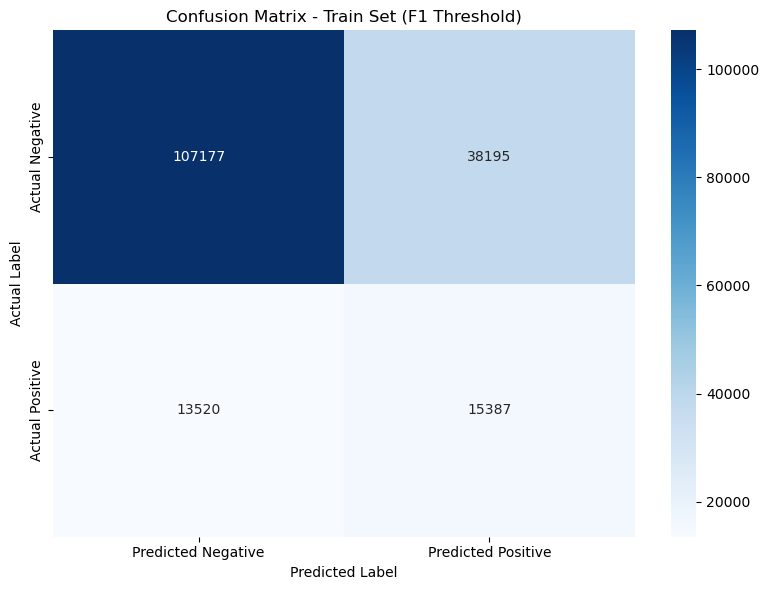

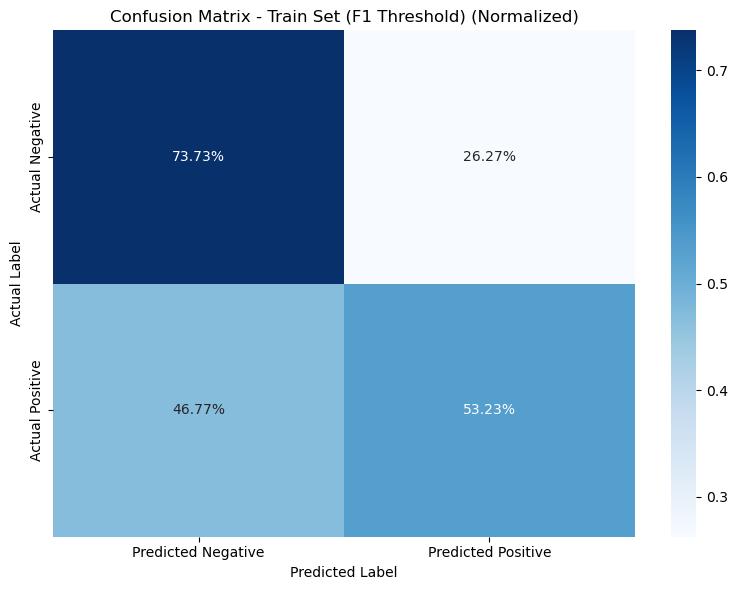

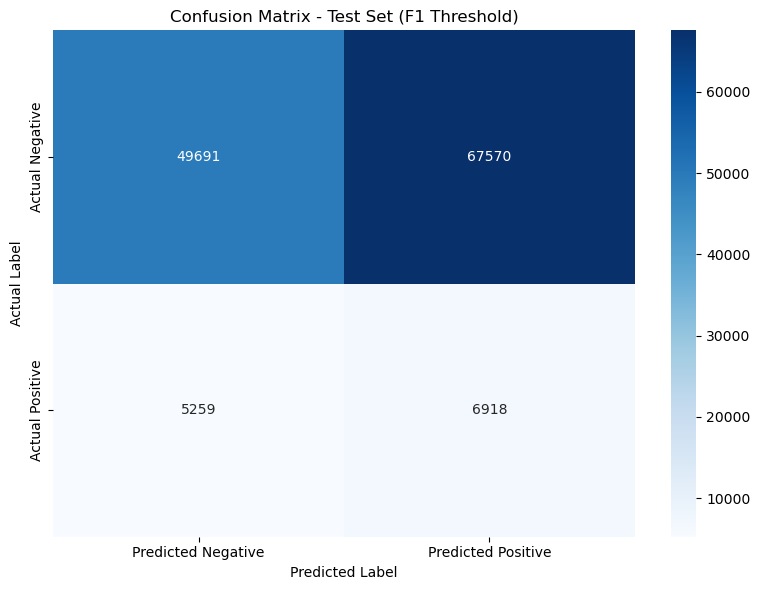

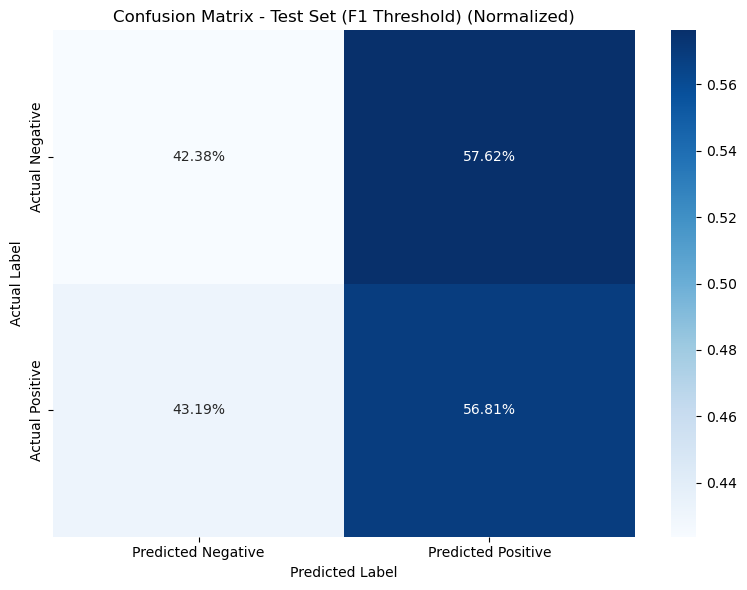

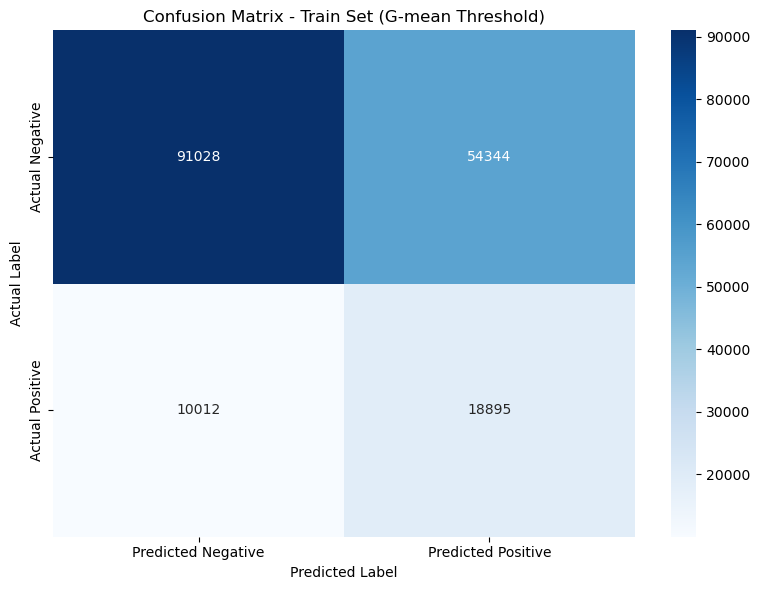

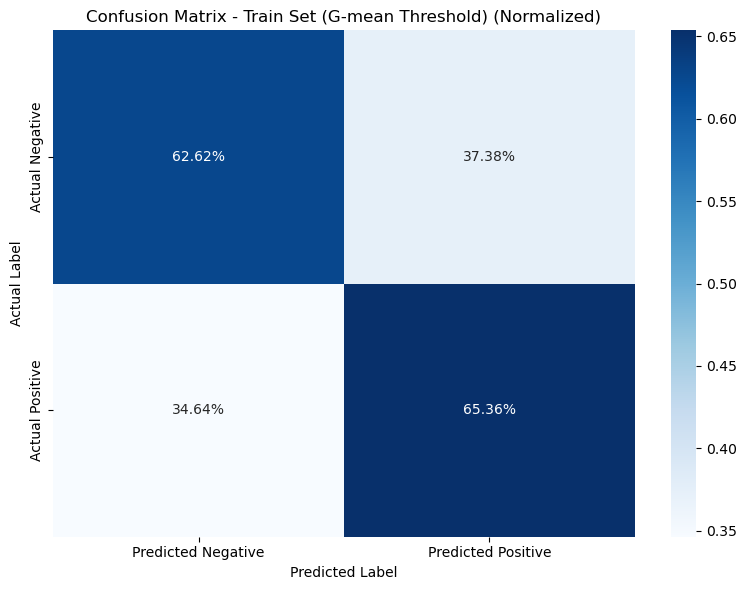

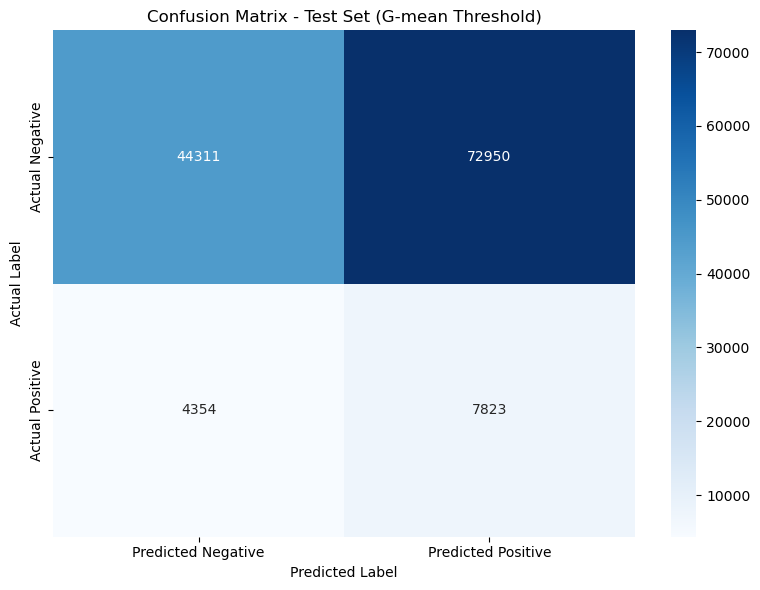

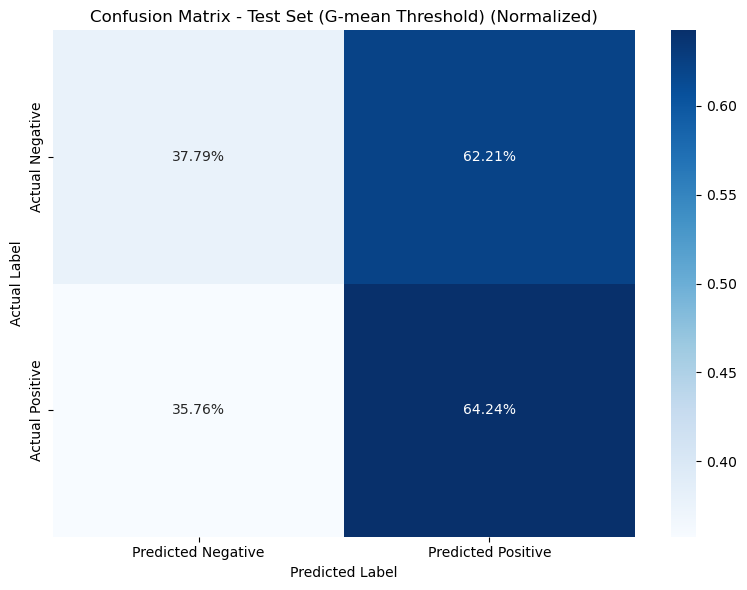

Plotting ROC curves...


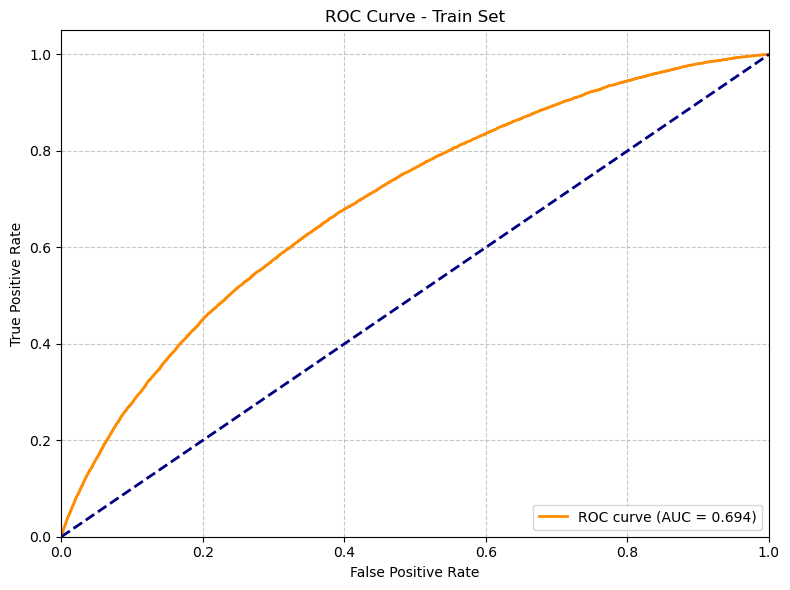

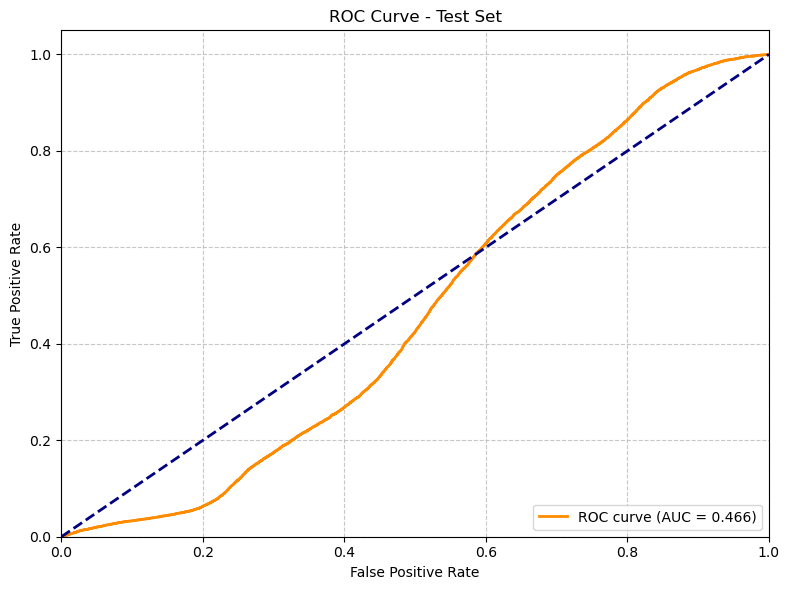

Plotting precision-recall curves...


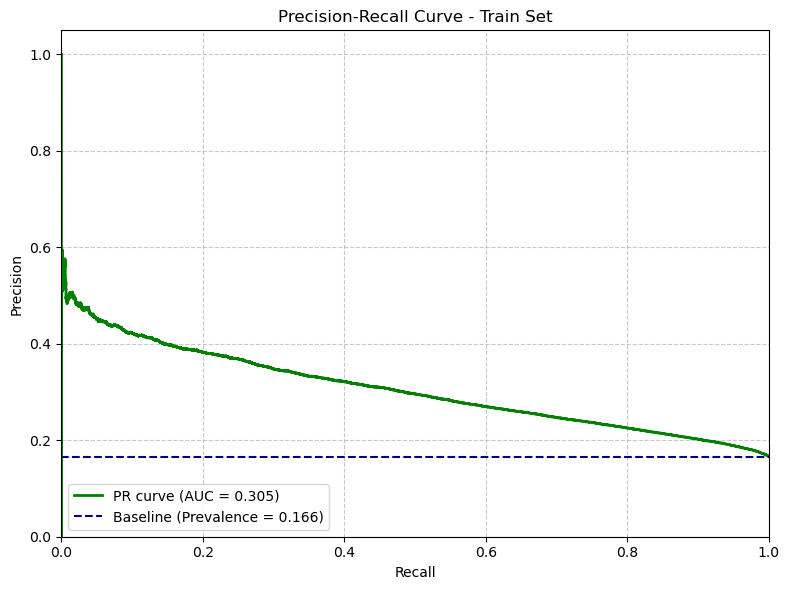

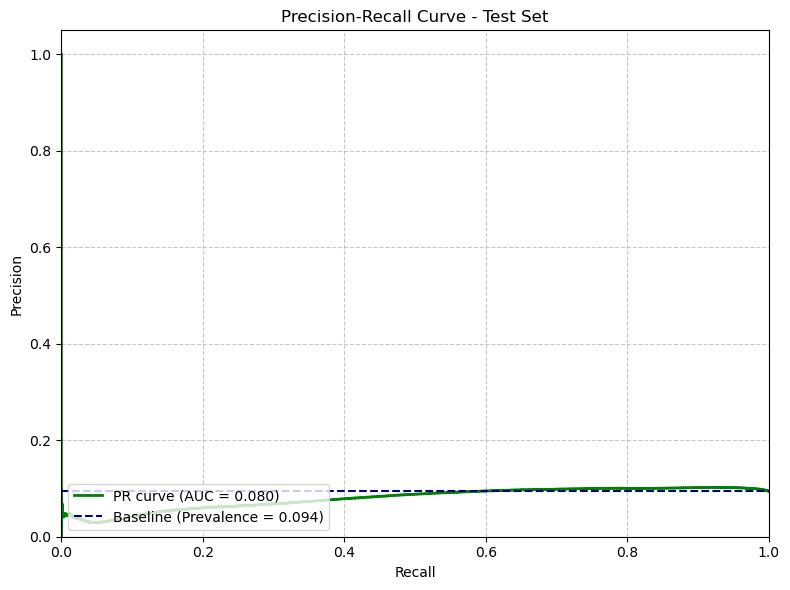

Plotting metrics comparison...


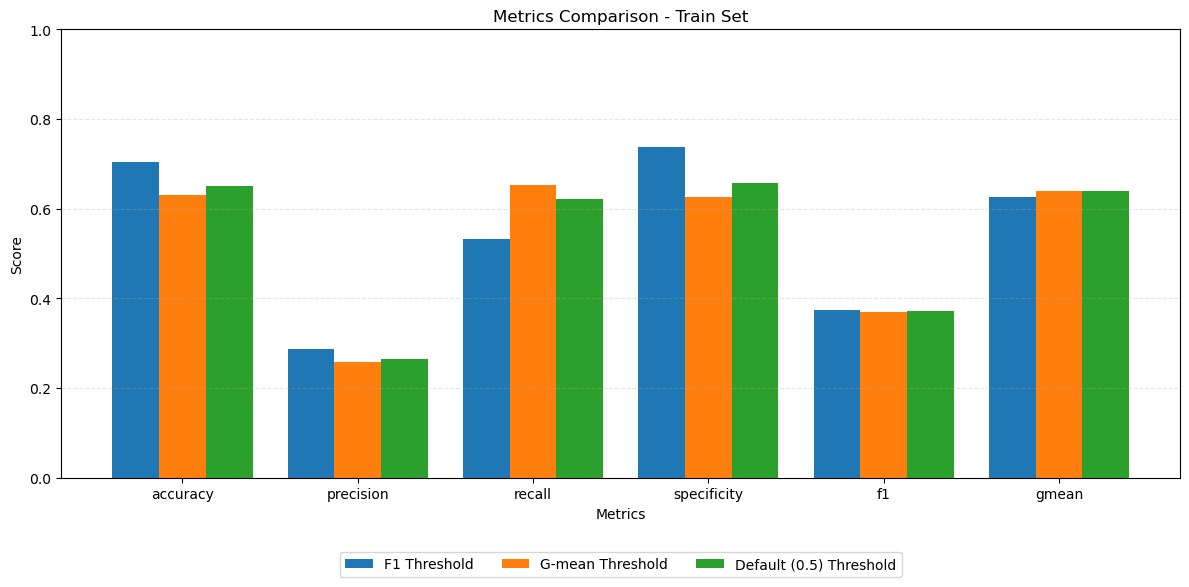

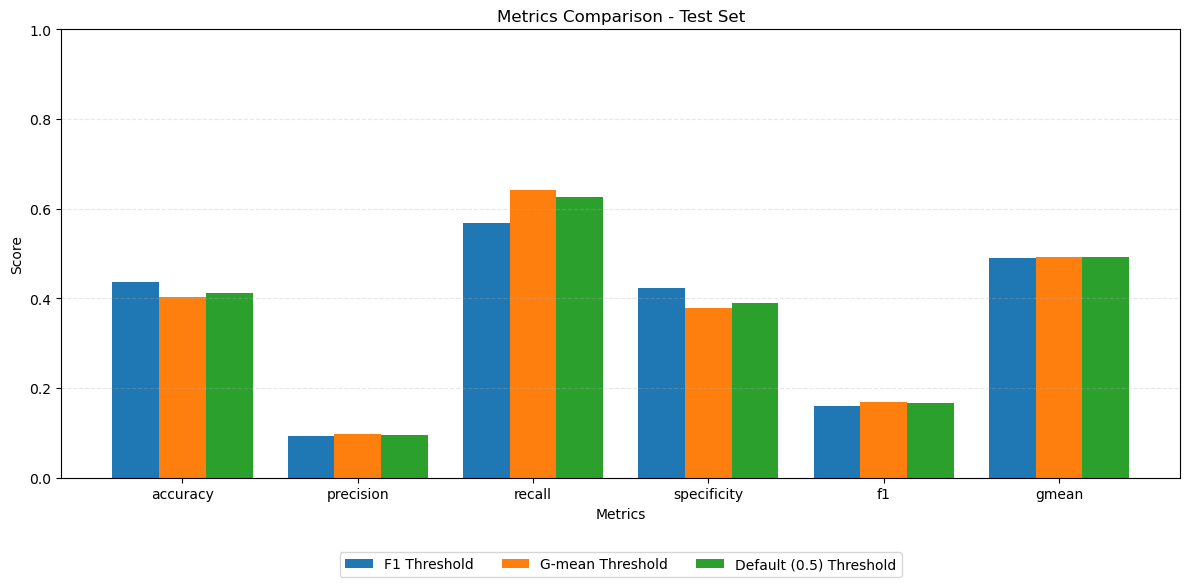

Plotting enhanced threshold curves...


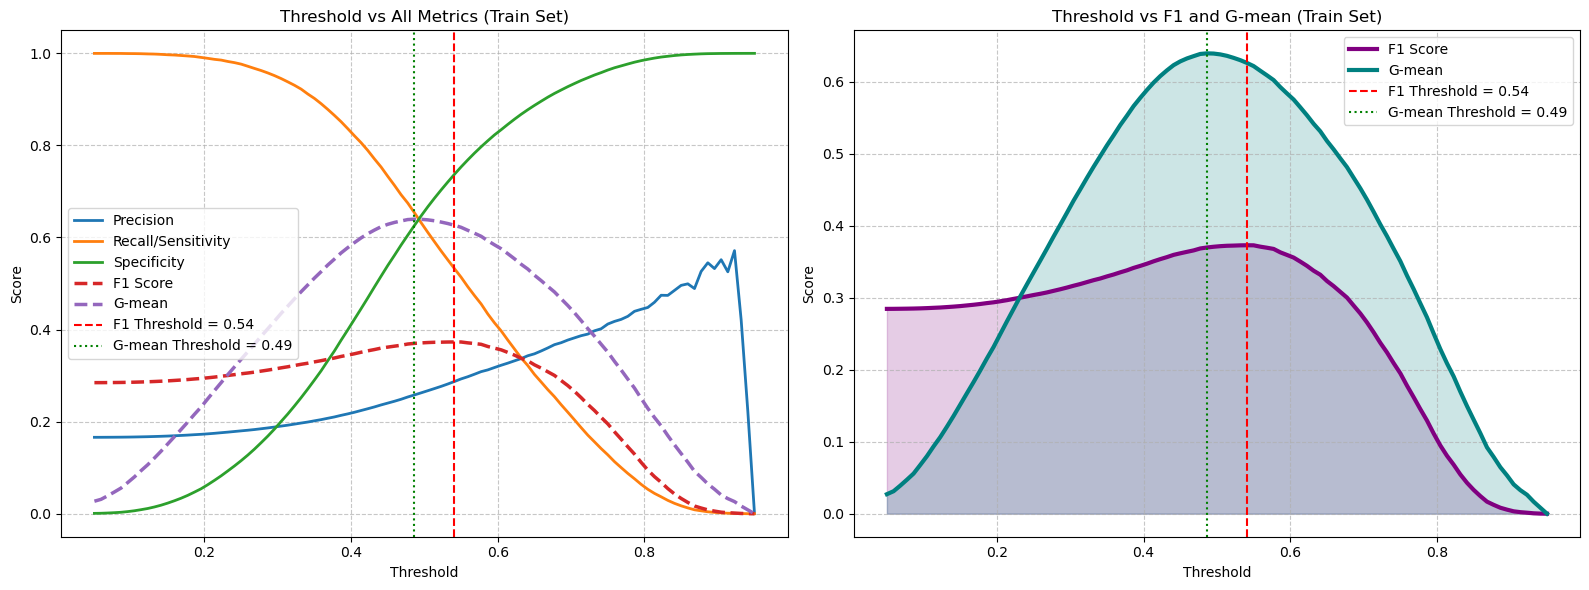

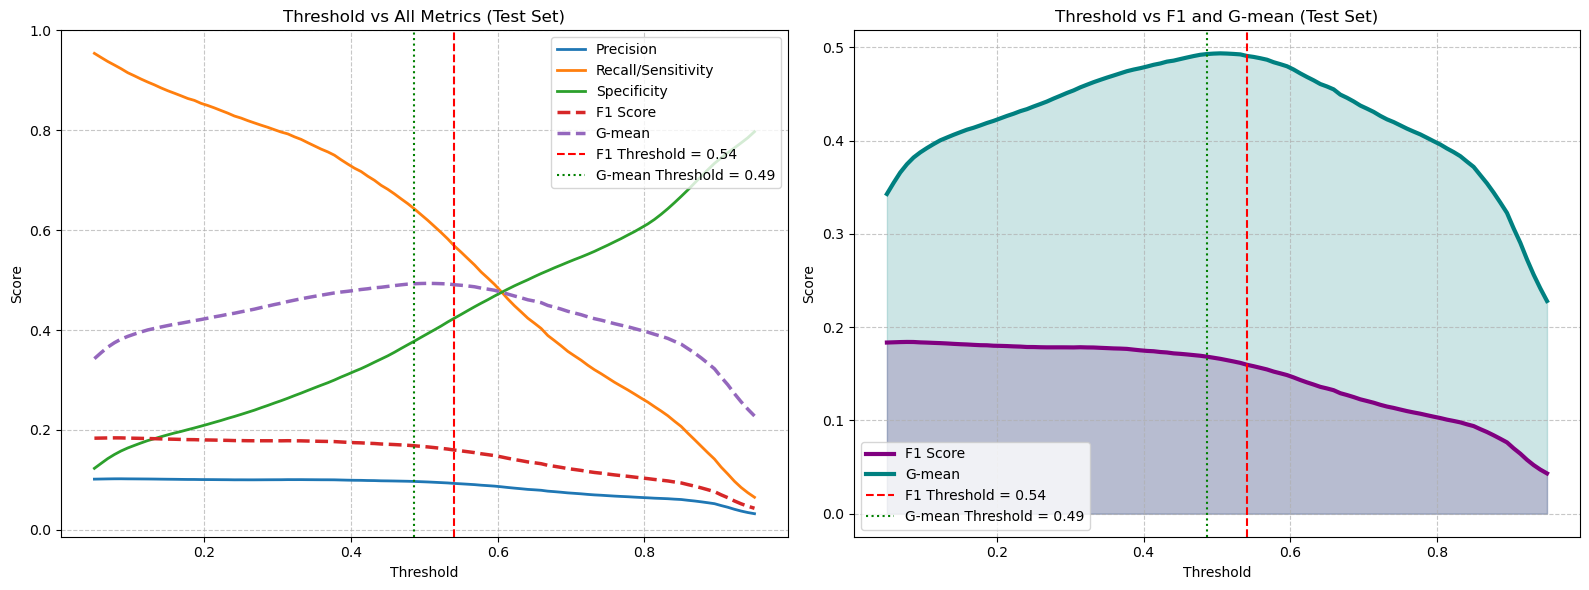

Plotting probability distributions...


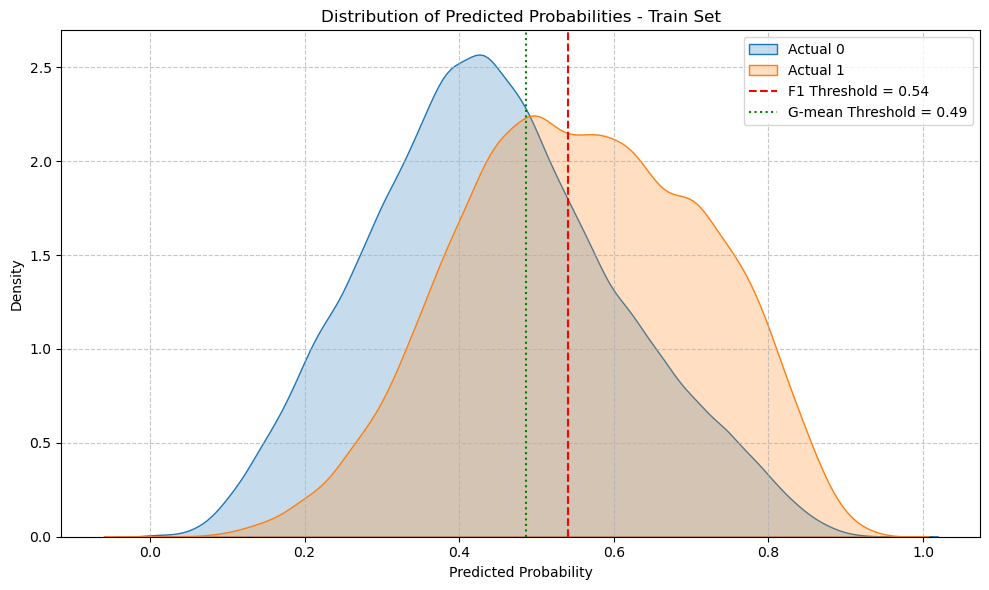

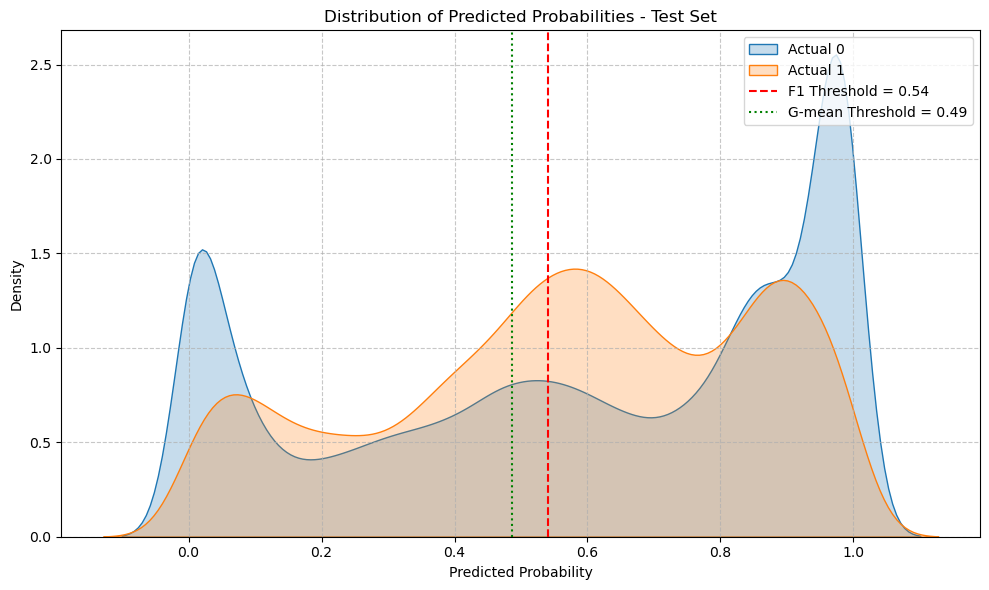


=== Summary ===
Optimized F1 threshold: 0.5409, Test F1: 0.1596, Test G-mean: 0.4907
Optimized G-mean threshold: 0.4864, Test F1: 0.1683, Test G-mean: 0.4927
Default threshold (0.5): Test F1: 0.1666, Test G-mean: 0.4934

Note: G-mean is primarily used for threshold selection in imbalanced datasets,
while the binary F1-score serves both for threshold selection and for evaluating model performance.


In [18]:
# === Run enhanced visualizations ===
print("\n=== Running Enhanced Visualizations ===")

# Generate predictions for G-mean threshold
y_train_pred_gmean = (y_train_prob >= best_thresh_gmean).astype(int)
y_test_pred_gmean = (y_test_prob >= best_thresh_gmean).astype(int)

# Evaluate with G-mean threshold
train_metrics_gmean = evaluate_model(y_train, y_train_pred_gmean, y_train_prob, "Train Set (G-mean threshold)")
test_metrics_gmean = evaluate_model(y_test, y_test_pred_gmean, y_test_prob, "Test Set (G-mean threshold)")

# Default threshold
baseline_train_pred = (y_train_prob >= 0.5).astype(int)
baseline_test_pred = (y_test_prob >= 0.5).astype(int)

# Evaluate baseline model
baseline_train_metrics = evaluate_model(y_train, baseline_train_pred, y_train_prob, "Train Set (Baseline)")
baseline_test_metrics = evaluate_model(y_test, baseline_test_pred, y_test_prob, "Test Set (Baseline)")

# 1. Confusion Matrix visualizations
print("Plotting confusion matrices...")
plot_confusion_matrix(train_metrics['confusion_matrix'], "Train Set (F1 Threshold)")
plot_confusion_matrix(test_metrics['confusion_matrix'], "Test Set (F1 Threshold)")
plot_confusion_matrix(train_metrics_gmean['confusion_matrix'], "Train Set (G-mean Threshold)")
plot_confusion_matrix(test_metrics_gmean['confusion_matrix'], "Test Set (G-mean Threshold)")

# 2. ROC Curves
print("Plotting ROC curves...")
plot_roc_curve(y_train, y_train_prob, "Train Set")
plot_roc_curve(y_test, y_test_prob, "Test Set")

# 3. Precision-Recall Curves
print("Plotting precision-recall curves...")
plot_precision_recall_curve(y_train, y_train_prob, "Train Set")
plot_precision_recall_curve(y_test, y_test_prob, "Test Set")

# 4. Metrics Comparison Charts
print("Plotting metrics comparison...")
plot_metrics_comparison(
    [train_metrics, train_metrics_gmean, baseline_train_metrics],
    ["F1 Threshold", "G-mean Threshold", "Default (0.5) Threshold"],
    "Train Set"
)
plot_metrics_comparison(
    [test_metrics, test_metrics_gmean, baseline_test_metrics],
    ["F1 Threshold", "G-mean Threshold", "Default (0.5) Threshold"],
    "Test Set"
)

# 5. Enhanced Threshold Curves
print("Plotting enhanced threshold curves...")
plot_enhanced_threshold_metrics(y_train, y_train_prob, "Train Set")
plot_enhanced_threshold_metrics(y_test, y_test_prob, "Test Set")

# 6. Probability Distributions
print("Plotting probability distributions...")
plot_probability_distribution(y_train, y_train_prob, "Train Set")
plot_probability_distribution(y_test, y_test_prob, "Test Set")

# Print summary
print("\n=== Summary ===")
print(f"Optimized F1 threshold: {best_thresh_f1:.4f}, Test F1: {test_metrics['f1']:.4f}, Test G-mean: {test_metrics['gmean']:.4f}")
print(f"Optimized G-mean threshold: {best_thresh_gmean:.4f}, Test F1: {test_metrics_gmean['f1']:.4f}, Test G-mean: {test_metrics_gmean['gmean']:.4f}")
print(f"Default threshold (0.5): Test F1: {baseline_test_metrics['f1']:.4f}, Test G-mean: {baseline_test_metrics['gmean']:.4f}")

print("\nNote: G-mean is primarily used for threshold selection in imbalanced datasets,")
print("while the binary F1-score serves both for threshold selection and for evaluating model performance.")